<img src="https://docs.xarray.dev/en/stable/_static/dataset-diagram-logo.png" align="right" width="30%">

# Parallel computing with Dask

This notebook demonstrates one of Xarray's most powerful features: the ability
to wrap [dask arrays](https://docs.dask.org/en/stable/array.html) and allow users to seamlessly execute analysis code in
parallel.

By the end of this notebook, you will:

1. Xarray DataArrays and Datasets are "dask collections" i.e. you can execute
   top-level dask functions such as `dask.visualize(xarray_object)`
2. Learn that all xarray built-in operations can transparently use dask


**Important:** *Using Dask does not always make your computations run faster!* 

Performance will depend on the computational infrastructure you're using (for example, how many CPU cores), how the data you're working with is structured and stored, and the algorithms and code you're running. Be sure to review the [Dask best-practices](https://docs.dask.org/en/stable/best-practices.html) if you're new to Dask!

## What is Dask

When we talk about Xarray + Dask, we are *usually* talking about two things:
1. `dask.array` as a drop-in replacement for numpy arrays
2. A "scheduler" that actually runs computations on dask arrays (commonly [distributed](https://docs.dask.org/en/stable/deploying.html))

## Introduction to dask.array

> Dask Array implements a subset of the NumPy ndarray interface using blocked algorithms, cutting up the large array into many small arrays (*blocks* or *chunks*). This lets us compute on arrays larger than memory using all of our cores. We coordinate these blocked algorithms using Dask graphs.

<img src="https://raw.githubusercontent.com/dask/dask/main/docs/source/images/dask-array.svg" style="width:55%">

In [1]:
import dask
import dask.array

dasky = dask.array.ones((10, 5), chunks=(2, 2))
dasky

dask.array<ones_like, shape=(10, 5), dtype=float64, chunksize=(2, 2), chunktype=numpy.ndarray>

### Why dask.array

1. Use parallel resources to speed up computation
2. Work with datasets bigger than RAM ("out-of-core")
    > "dask lets you scale from memory-sized datasets to disk-sized datasets"

### dask is lazy

Operations are not computed until you explicitly request them. 

In [2]:
dasky.mean(axis=-1)

dask.array<mean_agg-aggregate, shape=(10,), dtype=float64, chunksize=(2,), chunktype=numpy.ndarray>

**first an apology!**

So what did dask do when you called `.mean`? It added that operation to the "graph" or a blueprint of operations to execute later.

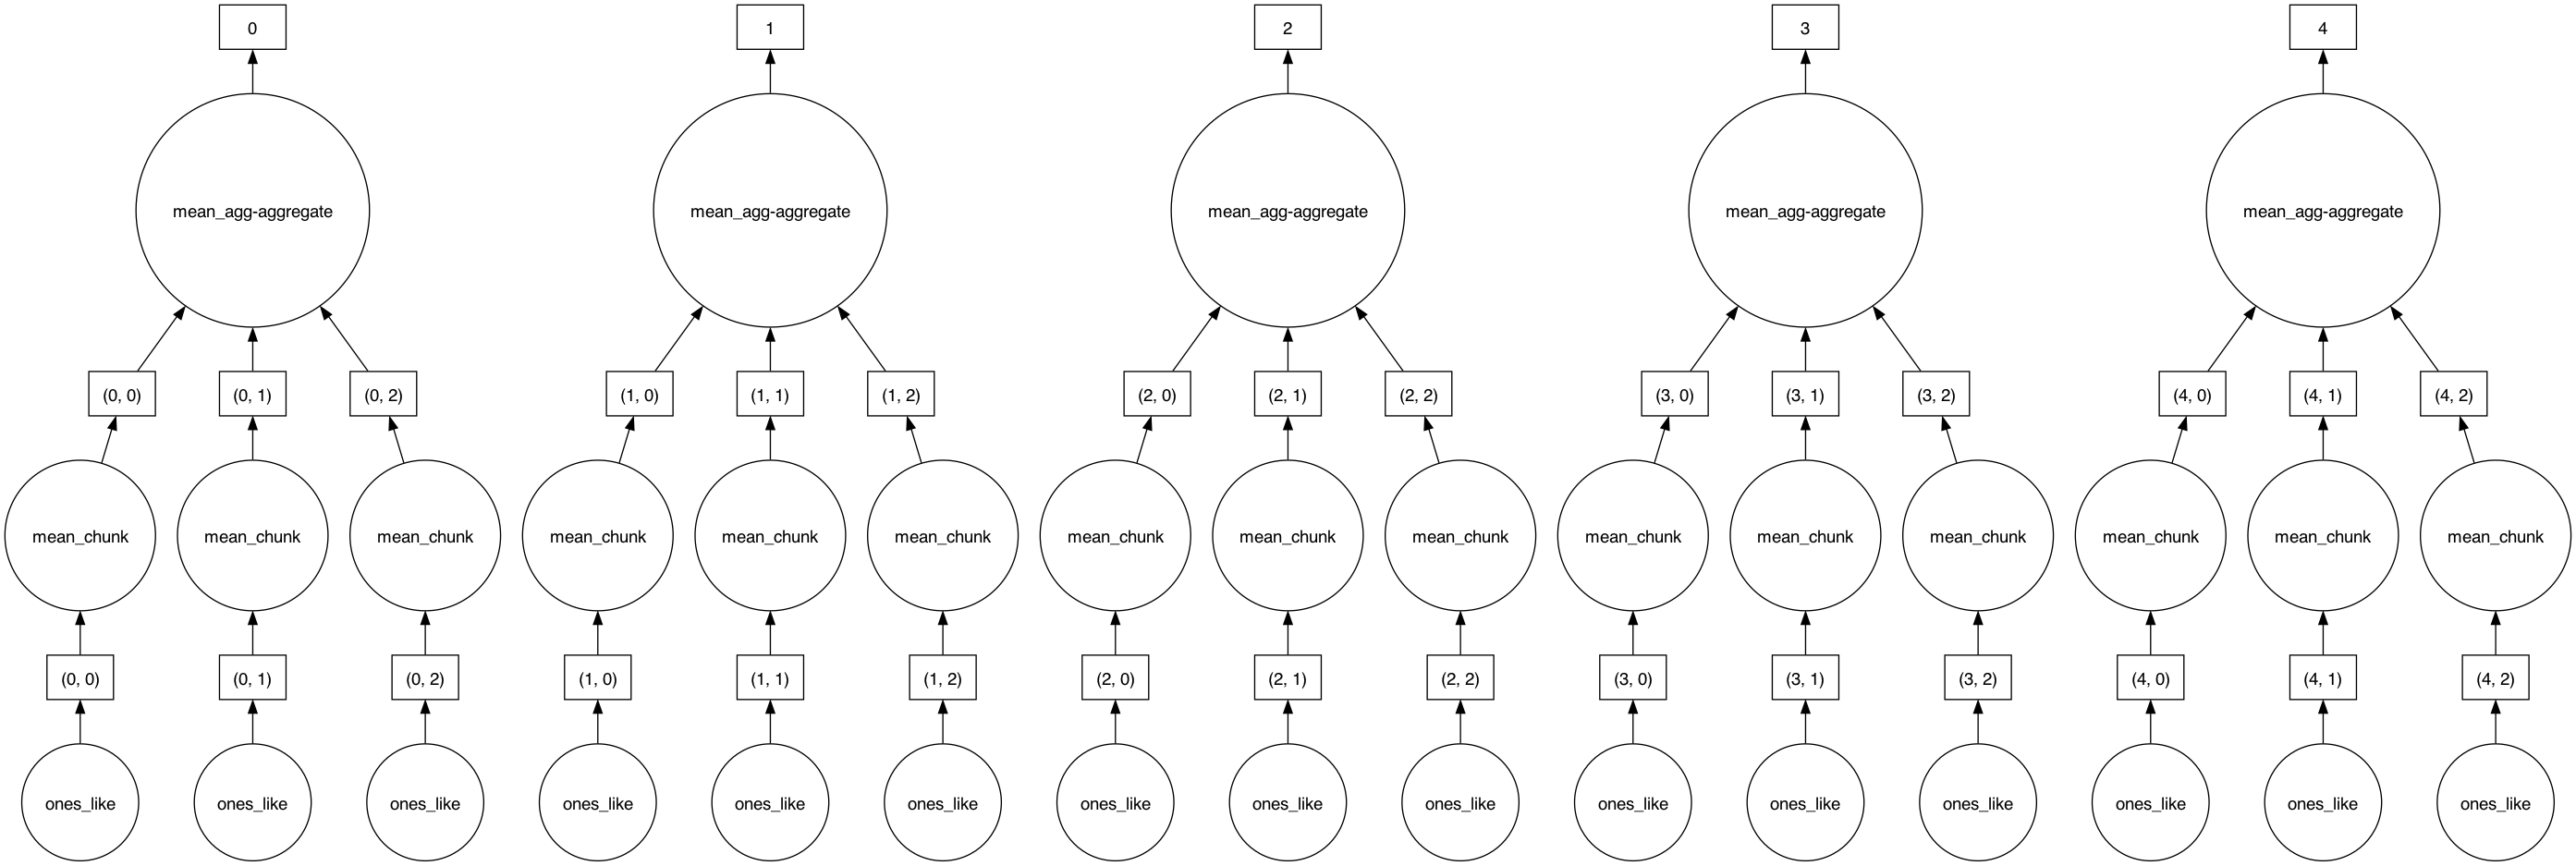

In [5]:
dask.visualize(dasky.mean(axis=-1))

In [6]:
dasky.mean(axis=-1).compute()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### More

See the [dask.array tutorial](https://tutorial.dask.org/02_array.html)


### Dask + Xarray

Remember that Xarray can wrap many different array types. So Xarray can wrap dask arrays too. 

We use Xarray to enable using our metadata to express our analysis.

<a id='readwrite'></a>

## Creating dask-backed Xarray objects

The `chunks` argument to both `open_dataset` and `open_mfdataset` allow you to
read datasets as dask arrays. 


In [7]:
import xarray as xr

In [8]:
ds = xr.tutorial.open_dataset("air_temperature")
ds.air

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
[3869000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [9]:
ds = xr.tutorial.open_dataset(
    "air_temperature",
    chunks={  # this tells xarray to open the dataset as a dask array
        "lat": "auto",
        "lon": 25,
        "time": -1,
    },
)
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 dask.array<chunksize=(2920, 25, 25), meta=np.ndarray>
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

The representation ("repr" in Python parlance) for the `air` DataArray shows the very nice HTML dask array repr. You can access the underlying chunk sizes using `.chunks`:

In [ ]:
ds.air.chunks

In [ ]:
ds

**Tip**: All variables in a `Dataset` need _not_ have the same chunk size along
common dimensions.

## Extracting underlying data

There are two ways to pull out the underlying array object in an xarray object.

1. `.to_numpy` or `.values` will always return a NumPy array. For dask-backed xarray objects,
   this means that compute will always be called
2. `.data` will return a Dask array

**tip**: Use `to_numpy` or `as_numpy` instead of `.values` so that your code generalizes to other array types (like CuPy arrays, sparse arrays)

In [ ]:
ds.air.data  # dask array, not numpy

In [ ]:
ds.air.as_numpy().data  ## numpy array

### Exercise

Try calling `ds.air.values` and `ds.air.data`. Do you understand the difference?

In [ ]:
ds.air.to_numpy()

<a id='compute'></a>

## Lazy computation 

Xarray seamlessly wraps dask so all computation is deferred until explicitly
requested.

In [ ]:
mean = ds.air.mean("time")
mean

Dask actually constructs a graph of the required computation. Here it's pretty simple: The full array is subdivided into 3 arrays. Dask will load each of these subarrays in a separate thread using the default [single-machine scheduling](https://docs.dask.org/en/stable/scheduling.html). You can visualize dask 'task graphs' which represent the requested computation:

In [ ]:
mean.data  # dask array

In [ ]:
# visualize the graph for the underlying dask array
# we ask it to visualize the graph from left to right because it looks nicer
dask.visualize(mean.data, rankdir="LR")

## Getting concrete values

At some point, you will want to actually get concrete values (_usually_ a numpy array) from dask.

There are two ways to compute values on dask arrays.

1. `.compute()` returns an xarray object *just like a dask array*
2. `.load()` replaces the dask array in the xarray object with a numpy array.
   This is equivalent to `ds = ds.compute()`
   
**Tip:** There is a third option : "persisting". `.persist()` loads the values into distributed RAM. The values are computed but remain distributed across workers. So `ds.air.persist()` still returns a dask array. This is useful if you will be repeatedly using a dataset for computation but it is too large to load into local memory. You will see a persistent task on the dashboard. See the [dask user guide](https://docs.dask.org/en/latest/api.html#dask.persist) for more on persisting


Think what to do with this tip. Whether to delete it or modify. 

### Exercise

Try running `mean.compute` and then examine `mean` after that. Is it still a dask array?

In [ ]:
mean

In [ ]:
mean.compute()

In [ ]:
mean

### Exercise

Now repeat that exercise with `mean.load`.

In [ ]:
mean.load()

In [ ]:
mean

## Distributed Clusters

As your data volumes grow and algorithms get more complex it can be hard to print out task graph representations and understand what Dask is doing behind the scenes. Luckily, you can use Dask's 'Distributed' scheduler to get very useful diagnotisic information.

First let's set up a `LocalCluster` using [dask.distributed](https://distributed.dask.org/).

You can use any kind of Dask cluster. This step is completely independent of
xarray. While not strictly necessary, the dashboard provides a nice learning
tool.

In [1]:
from dask.distributed import Client

# This piece of code is just for a correct dashboard link mybinder.org or other JupyterHub demos
import dask
import os

# if os.environ.get('JUPYTERHUB_USER'):
#    dask.config.set(**{"distributed.dashboard.link": "/user/{JUPYTERHUB_USER}/proxy/{port}/status"})

client = Client()
client

/Users/ynorden/miniconda3/envs/xarray-tutorial/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53590 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:53590/status,
Dashboard: http://127.0.0.1:53590/status,Workers: 5
Total threads: 10,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53591,Workers: 5
Dashboard: http://127.0.0.1:53590/status,Total threads: 10
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:53606,Total threads: 2
Dashboard: http://127.0.0.1:53611/status,Memory: 6.40 GiB
Nanny: tcp://127.0.0.1:53594,


☝️ Click the Dashboard link above. 

👈 Or click the "Search" 🔍 button in the [dask-labextension](https://github.com/dask/dask-labextension) dashboard.

NOTE: if using the dask-labextension, you should disable the 'Simple' JupyterLab interface (`View -> Simple Interface`), so that you can drag and rearrange whichever dashboards you want. The `Workers` and `Task Stream` are good to make sure the dashboard is working!

In [ ]:
import dask.array

dask.array.ones((1000, 4), chunks=(2, 1)).compute()  # should see activity in dashboard

## Computation

Let's go back to our xarray DataSet, in addition to computing the mean, other operations such as indexing will automatically use whichever Dask Cluster we are connected to!

In [ ]:
ds.air.isel(lon=1, lat=20)

and more complicated operations...


In [ ]:
rolling_mean = ds.air.rolling(time=5).mean()  # no activity on dashboard
rolling_mean  # contains dask array

In [ ]:
timeseries = rolling_mean.isel(lon=1, lat=20)  # no activity on dashboard
timeseries  # contains dask array

In [ ]:
computed = rolling_mean.compute()  # activity on dashboard
computed  # has real numpy values

Note that `mean` still contains a dask array


In [ ]:
rolling_mean

**tip** While these operations all work, not all of them are necessarily the optimal implementation for parallelism. Usually analysis pipelines need some tinkering and tweaking to get things to work. In particular read the user guidie recommendations for [chunking](https://docs.xarray.dev/en/stable/user-guide/dask.html#chunking-and-performance) and [performance](https://docs.xarray.dev/en/stable/user-guide/dask.html#optimization-tips)

## Xarray data structures are first-class dask collections.

This means you can do things like `dask.compute(xarray_object)`,
`dask.visualize(xarray_object)`, `dask.persist(xarray_object)`. This works for
both DataArrays and Datasets

### Exercise

Visualize the task graph for a few different computations on `ds.air`! 

## Finish up
Gracefully shutdown our connection to the Dask cluster. This becomes more important when you are running on large HPC or Cloud servers rather than a laptop!

In [ ]:
client.close()

## Next


See the [Xarray user guide on dask](https://docs.xarray.dev/en/stable/user-guide/dask.html). 